In [ ]:
format ELF64
public _start

section '.data' writable
    newline db 10

section '.bss' writable
    char_buffer db 1

section '.text' executable
_start:
    ; Получаем аргументы командной строки
    pop rcx        ; argc
    cmp rcx, 2
    jl exit        ; если нет аргументов - выходим

    pop rsi        ; argv[0] - имя программы (пропускаем)
    pop rsi        ; argv[1] - первый аргумент

    ; Преобразуем строку в число
    call str_to_int

    ; Выводим число
    call print_int

    ; Выводим новую строку
    mov rax, 1
    mov rdi, 1
    mov rsi, newline
    mov rdx, 1
    syscall

    call exit

; Преобразование строки в число
str_to_int:
    xor rax, rax
    xor rcx, rcx
    mov rbx, 10
.next_char:
    mov cl, [rsi]
    cmp cl, 0
    je .done
    cmp cl, '0'
    jl .done
    cmp cl, '9'
    jg .done
    sub cl, '0'
    imul rax, rbx
    add rax, rcx
    inc rsi
    jmp .next_char
.done:
    ret

; Вывод числа
print_int:
    mov rbx, 10
    xor rcx, rcx

.push_digits:
    xor rdx, rdx
    div rbx
    add dl, '0'
    push rdx
    inc rcx
    test rax, rax
    jnz .push_digits

.pop_digits:
    pop rax
    mov [char_buffer], al
    push rcx
    mov rax, 1
    mov rdi, 1
    mov rsi, char_buffer
    mov rdx, 1
    syscall
    pop rcx
    dec rcx
    jnz .pop_digits
    ret

exit:
    mov rax, 60
    xor rdi, rdi
    syscall


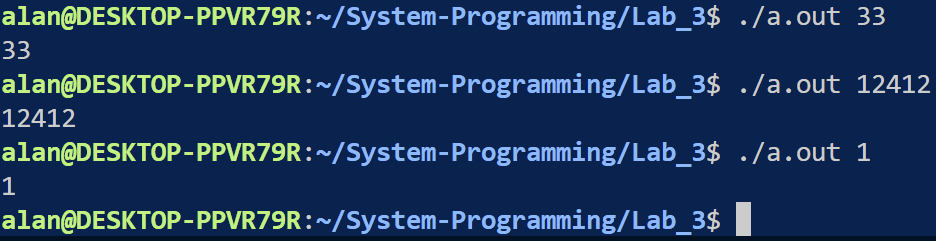

In [ ]:
format ELF64

section '.data' writeable
    division_error db "Error: Division by zero!", 10
    division_error_len = $ - division_error
    minus_sign db "-"
    newline db 10
    args_error db "Usage: program <c> <b>", 10
    args_error_len = $ - args_error
    remainder_msg db "Remainder: ", 0
    remainder_msg_len = $ - remainder_msg

section '.bss' writeable
    a dq ?
    b dq ?
    c dq ?
    result dq ?
    remainder dq ?
    char_buffer db ?

section '.text' executable
public _start

_start:
    ; Получаем аргументы командной строки
    pop rcx        ; argc
    cmp rcx, 3
    jl error_args

    ; Пропускаем первый аргумент (имя программы)
    pop rsi

    ; Читаем первый параметр (c)
    pop rsi
    call str_to_int
    mov [c], rax

    ; Читаем второй параметр (b)
    pop rsi
    call str_to_int
    mov [b], rax

    ; Проверка деления на ноль
    mov rax, [b]
    test rax, rax
    jnz calculate

    ; Ошибка деления на ноль
    mov rax, 1
    mov rdi, 1
    mov rsi, division_error
    mov rdx, division_error_len
    syscall
    jmp exit

error_args:
    ; Выводим сообщение об ошибке количества аргументов
    mov rax, 1
    mov rdi, 2
    mov rsi, args_error
    mov rdx, args_error_len
    syscall
    jmp exit

calculate:
    ; Вычисляем выражение: (((c-b)-b)/b)
    mov rax, [c]        ; RAX = c
    sub rax, [b]        ; RAX = c - b
    sub rax, [b]        ; RAX = (c - b) - b

    ; Подготовка к делению
    cqo                 ; Расширяем RAX в RDX:RAX (знаковое)
    idiv qword [b]      ; RAX = результат, RDX = остаток

    ; Сохраняем результат
    mov [result], rax
    mov [remainder], rdx

    ; Вывод результата
    mov rax, [result]
    call print_int

    ; Вывод перевода строки
    call new_line

    ; Если есть остаток, выводим его
    cmp qword [remainder], 0
    je exit

    ; Вывод остатка
    mov rax, 1
    mov rdi, 1
    mov rsi, remainder_msg
    mov rdx, remainder_msg_len
    syscall

    mov rax, [remainder]
    call print_int
    call new_line

exit:
    ; Завершение программы
    mov rax, 60
    xor rdi, rdi
    syscall

; Функция преобразования строки в число
str_to_int:
    xor rax, rax
    xor rcx, rcx
    mov rbx, 10
.iterate:
    mov cl, [rsi]
    cmp cl, 0
    je .done
    cmp cl, '0'
    jl .done
    cmp cl, '9'
    jg .done
    sub cl, '0'
    imul rax, rbx
    add rax, rcx
    inc rsi
    jmp .iterate
.done:
    ret

; Функция вывода числа
print_int:
    push rbx
    push rcx
    push rdx
    mov rcx, 10
    xor rbx, rbx

    ; Проверка на отрицательное число
    test rax, rax
    jns .positive
    push rax
    mov rax, 1
    mov rdi, 1
    mov rsi, minus_sign
    mov rdx, 1
    syscall
    pop rax
    neg rax

.positive:
.digit_loop:
    xor rdx, rdx
    div rcx
    add dl, '0'
    push rdx
    inc rbx
    test rax, rax
    jnz .digit_loop

.print_loop:
    pop rax
    call print_char
    dec rbx
    jnz .print_loop

    pop rdx
    pop rcx
    pop rbx
    ret

; Функция вывода символа
print_char:
    push rdi
    push rsi
    push rdx
    mov [char_buffer], al
    mov rax, 1
    mov rdi, 1
    mov rsi, char_buffer
    mov rdx, 1
    syscall
    pop rdx
    pop rsi
    pop rdi
    ret

; Функция вывода перевода строки
new_line:
    push rax
    push rdi
    push rsi
    push rdx
    mov rax, 1
    mov rdi, 1
    mov rsi, newline
    mov rdx, 1
    syscall
    pop rdx
    pop rsi
    pop rdi
    pop rax
    ret


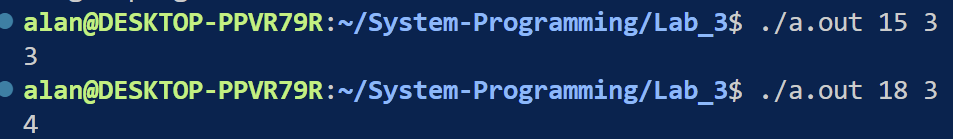

In [ ]:
#include <stdio.h>
#include <stdlib.h>

int main(int argc, char *argv[]) {
    if (argc != 3) {
        printf("%s b c\n", argv[0]);
        return 1;
    }

    int b = atoi(argv[1]);
    int c = atoi(argv[2]);

    if (b == 0) {
        printf("Ошибк! Деление на 0\n");
        return 1;
    }

    int res = (((c-b)-b)/b);
    printf("%d\n", res);

    return 0;
}


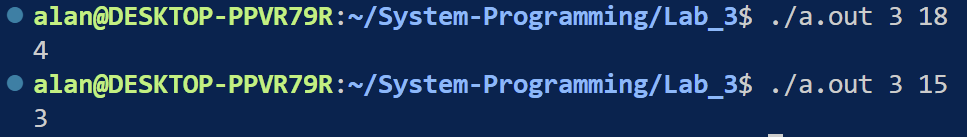